In [1]:
import datetime; datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

'2022-06-15 17:34:24'

# Incoming weights for the learner are fixed

## Comparing the decorrelation methods in this setting

In [2]:
import mariadb
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
import matplotlib.ticker as ticker

%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
sns.set(
rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'black',
 'axes.facecolor': 'None',
 'axes.grid': False,
 "grid.color": "lightgrey",
 'axes.labelcolor': 'black',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'black',
 'xtick.bottom': False,
 'xtick.color': 'black',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'black',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False,
    })
plt.rcParams["figure.figsize"] = (30,7)
sns.set_context("notebook", rc={"font.size":20,
                                "axes.titlesize":20,
                                "axes.labelsize":15})
# paper config below (uncomment)

plt.rcParams.update({
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'font.size': 15,
    'figure.autolayout': True,
    'figure.figsize': (7.2,4.45),
    'axes.titlesize' : 16,
    'axes.labelsize' : 17,
    'lines.linewidth' : 2,
    'lines.markersize' : 6,
    'legend.fontsize': '13',
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral',
    
    })

# some irrelavant config
#CB91_Blue = '#2CBDFE'
#CB91_Green = '#47DBCD'
#CB91_Pink = '#F3A0F2'
#CB91_Purple = '#9D2EC5'
#CB91_Violet = '#661D98'
#CB91_Amber = '#F5B14C'
#color_list = [CB91_Purple, CB91_Blue, CB91_Pink, CB91_Green,
#              CB91_Amber, CB91_Violet]
#plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette("bright"))
sns.color_palette("bright")

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

In [4]:
from cycler import cycler

fsize = 15
tsize = 18
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.7
lhandle = 2.0
plt.style.use('default')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

line_cycler   = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["-", "--", "-.", ":", "-", "--", "-."]))
marker_cycler = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["none", "none", "none", "none", "none", "none", "none"]) +
                 cycler(marker=["4", "2", "3", "1", "+", "x", "."]))
standard_cycler = cycler("color", ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"])
plt.rc("axes", prop_cycle=standard_cycler)


In [5]:
class DbAccessor:
    def __init__(self, db_name, cfg_primary_key="run_id", timestep_col_name="episode", local=False, gc=False, gc2=False):
        #params:
        #    cfg_primary_key: the key that is used to index the runs
        #    timestep_col_name: the column which contains the timestep values to be used in plots (or any other column to index with/use as x-axis)
        self.cfg_primary_key = cfg_primary_key
        self.timestep_col_name = timestep_col_name
        try:
            if local:
                    self.conn = mariadb.connect(user="haseebs",
                                                password="",
                                                host="localhost",
                                                port=3306,
                                                database=db_name)
            elif gc:
                self.conn = mariadb.connect(user='rlai',
                                            password=os.environ['gcpswd'],
                                            host='35.203.104.151',
                                            database=db_name)
            elif gc2:
                self.conn = mariadb.connect(user='narval',
                                            password=os.environ['narvalpswd'],
                                            host='34.152.53.247',
                                            database=db_name)
            else:
                # requires ssh tunnel to ccdb
                self.conn = mariadb.connect(user='hshah1',
                                            password=os.environ['cedarsqlpswd'],
                                            host='127.0.0.1',
                                            port=3307,
                                            database=db_name)
        except mariadb.Error as e:
            print(f"Error connecting to MariaDB Platform: {e}")
            sys.exit(1)

    def get_table_list(self):
        return pd.read_sql('show tables', self.conn)
    
    def get_table(self, table_name, cfg_filter=None, column_names="*", index=True):
        #params:
        #    cfg_filter: optional value of <cfg_primary_key> to filter the results with
        #    column_names: can be multiple
        #    index: whether the current table is indexed by <timestep_col_name>
        #returns:
        #    <timestep_col_name>'s values + <column_names>'s values
        
        #TODO careful with column names in future...
        if index:
            if column_names != "*":
                column_names += f',{self.timestep_col_name}'

            if cfg_filter:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name} WHERE {self.cfg_primary_key}={cfg_filter}', self.conn).set_index(self.timestep_col_name)
            else:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name}', self.conn).set_index(self.timestep_col_name)            
        else:
            if cfg_filter:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name} WHERE {self.cfg_primary_key}={cfg_filter}', self.conn)
            else:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name}', self.conn)


In [6]:
db1 = DbAccessor('hshah1_0302_no_decor_n2_decor_sweep', cfg_primary_key="run", timestep_col_name="step", local=False, gc=True)
pd.read_sql(f'select * from runs', db1.conn)

,name,age_restriction,min_estimation_period,n2_decorrelate,n_distractors,n_inputs,n_learner_features,n_target_features,random_decorrelate,random_replacement,replace_every,replace_perc,seed,step_size,steps,sum_features,run
0,0302_no_decor_n2_decor_sweep,0,5000,0,0,5,50,10,0,0,5000,0.2,0,0.10000,1000001,0,0
1,0302_no_decor_n2_decor_sweep,0,5000,1,0,5,50,10,0,0,5000,0.2,0,0.10000,1000001,0,1
2,0302_no_decor_n2_decor_sweep,0,5000,0,0,5,50,50,0,0,5000,0.2,0,0.10000,1000001,0,2
3,0302_no_decor_n2_decor_sweep,0,5000,1,0,5,50,50,0,0,5000,0.2,0,0.10000,1000001,0,3
4,0302_no_decor_n2_decor_sweep,0,5000,0,0,5,50,500,0,0,5000,0.2,0,0.10000,1000001,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,0302_no_decor_n2_decor_sweep,0,5000,1,0,5,50,10,0,0,5000,0.2,9,0.00001,1000001,0,1195
1196,0302_no_decor_n2_decor_sweep,0,5000,0,0,5,50,50,0,0,5000,0.2,9,0.00001,1000001,0,1196
1197,0302_no_decor_n2_decor_sweep,0,5000,1,0,5,50,50,0,0,5000,0.2,9,0.00001,1000001,0,1197
1198,0302_no_decor_n2_decor_sweep,0,5000,0,0,5,50,500,0,0,5000,0.2,9,0.00001,1000001,0,1198


In [7]:
db2 = DbAccessor('hshah1_0310_random_decor_sweep_retry', cfg_primary_key="run", timestep_col_name="step", local=False, gc=True)
pd.read_sql(f'select * from runs', db2.conn)

,name,age_restriction,min_estimation_period,n2_decorrelate,n_distractors,n_inputs,n_learner_features,n_target_features,random_decorrelate,random_replacement,replace_every,replace_perc,seed,step_size,steps,sum_features,run
0,0310_random_decor_sweep_retry,0,1000,0,0,5,50,10,1,0,5000,0.2,0,0.10000,1000001,0,0
1,0310_random_decor_sweep_retry,0,5000,0,0,5,50,10,1,0,5000,0.2,0,0.10000,1000001,0,1
2,0310_random_decor_sweep_retry,0,10000,0,0,5,50,10,1,0,5000,0.2,0,0.10000,1000001,0,2
3,0310_random_decor_sweep_retry,0,20000,0,0,5,50,10,1,0,5000,0.2,0,0.10000,1000001,0,3
4,0310_random_decor_sweep_retry,0,1000,0,0,5,50,50,1,0,5000,0.2,0,0.10000,1000001,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,0310_random_decor_sweep_retry,0,20000,0,0,5,50,50,1,0,5000,0.2,9,0.00001,1000001,0,2395
2396,0310_random_decor_sweep_retry,0,1000,0,0,5,50,500,1,0,5000,0.2,9,0.00001,1000001,0,2396
2397,0310_random_decor_sweep_retry,0,5000,0,0,5,50,500,1,0,5000,0.2,9,0.00001,1000001,0,2397
2398,0310_random_decor_sweep_retry,0,10000,0,0,5,50,500,1,0,5000,0.2,9,0.00001,1000001,0,2398


In [8]:
db3 = DbAccessor('hshah1_0311_random_thresh_decor_sweep', cfg_primary_key="run", timestep_col_name="step", local=False, gc=True)
pd.read_sql(f'select * from runs', db3.conn)

,name,age_restriction,min_estimation_period,n2_decorrelate,n_distractors,n_inputs,n_learner_features,n_target_features,random_decorrelate,random_replacement,random_thresh_decorrelate,replace_every,replace_perc,seed,step_size,steps,sum_features,run
0,0311_random_thresh_decor_sweep,0,1000,0,0,5,50,10,0,0,1,5000,0.2,0,0.10000,1000001,0,0
1,0311_random_thresh_decor_sweep,0,5000,0,0,5,50,10,0,0,1,5000,0.2,0,0.10000,1000001,0,1
2,0311_random_thresh_decor_sweep,0,10000,0,0,5,50,10,0,0,1,5000,0.2,0,0.10000,1000001,0,2
3,0311_random_thresh_decor_sweep,0,20000,0,0,5,50,10,0,0,1,5000,0.2,0,0.10000,1000001,0,3
4,0311_random_thresh_decor_sweep,0,1000,0,0,5,50,50,0,0,1,5000,0.2,0,0.10000,1000001,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2395,0311_random_thresh_decor_sweep,0,20000,0,0,5,50,50,0,0,1,5000,0.2,9,0.00001,1000001,0,2395
2396,0311_random_thresh_decor_sweep,0,1000,0,0,5,50,500,0,0,1,5000,0.2,9,0.00001,1000001,0,2396
2397,0311_random_thresh_decor_sweep,0,5000,0,0,5,50,500,0,0,1,5000,0.2,9,0.00001,1000001,0,2397
2398,0311_random_thresh_decor_sweep,0,10000,0,0,5,50,500,0,0,1,5000,0.2,9,0.00001,1000001,0,2398


In [9]:
def plt_individual(comment, NSTEPS, min_steps, db, colors, label=None, condition=[], table='test_metrics', plot_conf=True, linestyle='-', pkey_col = "run_id", nocomment=False, nolabel=False, linewidth=None, col=None, alpha=1):
    #NSTEPS : number of entries
    if label==None:
        label=comment
    if col is None:
        if table == 'training_metrics':
            col = 'running_acc'
        elif table == 'error_table' or table == "test_accuracy":
            col = 'error'
        else:
            col = 'acc'
    suitable_runs = pd.read_sql(f'select {pkey_col} from {table} group by {pkey_col} having max({db.timestep_col_name}) > {min_steps}', db.conn).values
    #suitable_runs = [s for s in suitable_runs if len(db.get_table(table, s[0], col).values.reshape(-1)) >= NSTEPS]
        
    runs = []
    invalid_count = 0
    if nocomment:
        # too lazy
        if condition == []:
            r = pd.read_sql(f'select {pkey_col} from runs ', db.conn).values
        elif len(condition) == 1:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} ', db.conn).values
        elif len(condition) == 2:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} ', db.conn).values
        elif len(condition) == 3:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]}', db.conn).values
        elif len(condition) == 4:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]} and {condition[3][0]} = {condition[3][1]}', db.conn).values
        elif len(condition) == 5:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]} and {condition[3][0]} = {condition[3][1]} and {condition[4][0]} = {condition[4][1]}', db.conn).values
        if len(r) !=0:
            runs = r

    runs = [r for r in runs if len(db.get_table(table, r[0], col).values.reshape(-1)) >= NSTEPS]
    if len(runs) == 0:
        print("\t 0 runs for ", condition)
        return False
    else:
        print(f'\t Found {len(runs)} valid runs for {condition}')

    acc_all = np.zeros((len(runs), NSTEPS))
    for i,run in enumerate(runs):
        acc_all[i,:] =  db.get_table(table, run[0], col).values[:NSTEPS].reshape(-1)
    acc_mean = np.mean(acc_all, axis=0)
    
    x_axis = db.get_table(table, run[0], col).index[:NSTEPS].to_numpy()
    if linewidth is None:
        linewidth = plt.rcParams["lines.linewidth"]
        if linestyle == ":":
            linewidth = plt.rcParams["lines.linewidth"]/2
    
    for i, run in enumerate(runs):
        plt.plot(x_axis, acc_all[i,:], label=f"run {i}", color=colors[i], linestyle=linestyle, linewidth=linewidth, alpha=alpha)
    return True

In [10]:
def plt_individual_corr(comment, NSTEPS, min_steps, db, colors, label=None, condition=[], table='test_metrics', plot_conf=True, linestyle='-', pkey_col = "run_id", nocomment=False, nolabel=False, linewidth=None, col=None, alpha=1, features=50):
    #NSTEPS : number of entries
    if label==None:
        label=comment
    if col is None:
        if table == 'training_metrics':
            col = 'running_acc'
        elif table == 'error_table' or table == "test_accuracy":
            col = 'error'
        else:
            col = 'acc'
    suitable_runs = pd.read_sql(f'select {pkey_col} from {table} group by {pkey_col} having max({db.timestep_col_name}) > {min_steps}', db.conn).values
    #suitable_runs = [s for s in suitable_runs if len(db.get_table(table, s[0], col).values.reshape(-1)) >= NSTEPS]
        
    runs = []
    invalid_count = 0
    if nocomment:
        # too lazy
        if condition == []:
            r = pd.read_sql(f'select {pkey_col} from runs ', db.conn).values
        elif len(condition) == 1:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} ', db.conn).values
        elif len(condition) == 2:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} ', db.conn).values
        elif len(condition) == 3:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]}', db.conn).values
        elif len(condition) == 4:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]} and {condition[3][0]} = {condition[3][1]}', db.conn).values
        elif len(condition) == 5:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]} and {condition[3][0]} = {condition[3][1]} and {condition[4][0]} = {condition[4][1]}', db.conn).values
        if len(r) !=0:
            runs = r

    runs = [r for r in runs if len(db.get_table(table, r[0], col).values.reshape(-1)) >= NSTEPS]
    if len(runs) == 0:
        print("\t 0 runs for ", condition)
        return False
    else:
        print(f'\t Found {len(runs)} valid runs for {condition}')

    acc_all = np.zeros((len(runs), NSTEPS))
    for i,run in enumerate(runs):
        acc_all[i,:] =  db.get_table(table, run[0], col).values[:NSTEPS].reshape(-1)
    acc_mean = np.mean(acc_all, axis=0)
    
    x_axis = db.get_table(table, run[0], col).index[:NSTEPS].to_numpy()
    if linewidth is None:
        linewidth = plt.rcParams["lines.linewidth"]
        if linestyle == ":":
            linewidth = plt.rcParams["lines.linewidth"]/2
    
    for i, run in enumerate(runs):
        plt.plot(x_axis, 100*acc_all[i,:]/features, label=f"run {i}", color=colors[i], linestyle=linestyle, linewidth=linewidth, alpha=alpha)
    return True

In [11]:
def plt_with_err_mature(comment, NSTEPS, min_steps, db, color, label=None, condition=[], table='test_metrics', plot_conf=True, linestyle='-', pkey_col = "run_id", nocomment=False, nolabel=False, linewidth=None, col=None, features=50):
    #NSTEPS : number of entries
    if label==None:
        label=comment
        
    col = "n_mature"
    suitable_runs = pd.read_sql(f'select {pkey_col} from {table} group by {pkey_col} having max({db.timestep_col_name}) > {min_steps}', db.conn).values
    #suitable_runs = [s for s in suitable_runs if len(db.get_table(table, s[0], col).values.reshape(-1)) >= NSTEPS]
        
    runs = []
    invalid_count = 0
    if nocomment:
        # too lazy
        if condition == []:
            r = pd.read_sql(f'select {pkey_col} from runs ', db.conn).values
        elif len(condition) == 1:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} ', db.conn).values
        elif len(condition) == 2:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} ', db.conn).values
        elif len(condition) == 3:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]}', db.conn).values
        elif len(condition) == 4:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]} and {condition[3][0]} = {condition[3][1]}', db.conn).values
        elif len(condition) == 5:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]} and {condition[3][0]} = {condition[3][1]} and {condition[4][0]} = {condition[4][1]}', db.conn).values
        if len(r) !=0:
            runs = r

    runs = [r for r in runs if len(db.get_table(table, r[0], col).values.reshape(-1)) >= NSTEPS]
    if len(runs) == 0:
        print("\t 0 runs for ", condition)
        return False
    else:
        print(f'\t Found {len(runs)} valid runs for {condition}')

        
    acc_sums = 0
    total_runs = 0
    for run in runs:
        acc_sums += db.get_table(table, run[0], col).values[:NSTEPS].reshape(-1)
        total_runs += 1
    mean_acc = acc_sums / total_runs



    acc_all = np.zeros((len(runs), NSTEPS))
    for i,run in enumerate(runs):
        acc_all[i,:] =  100*db.get_table(table, run[0], col).values[:NSTEPS].reshape(-1) / features
    acc_mean = np.mean(acc_all, axis=0)
    acc_std = np.std(acc_all, axis=0)/np.sqrt(total_runs)
    x_axis = db.get_table(table, run[0], col).index[:NSTEPS].to_numpy()
    #plt.errorbar(x_axis, acc_mean, yerr=acc_std*1.96, label=f"{label} | runs: {total_runs} | invalid: {invalid_count}", color=color)
    if linewidth is None:
        linewidth = plt.rcParams["lines.linewidth"]
            
    if nolabel:
        plt.plot(x_axis, acc_mean, color=color, linestyle=linestyle, linewidth=linewidth)
    else:
        plt.plot(x_axis, acc_mean, label=f"{label} | valid runs: {total_runs}", color=color, linestyle=linestyle, linewidth=linewidth)
        #plt.plot(x_axis, acc_mean, label=f"{label}", color=color, linestyle=linestyle, linewidth=linewidth)
    if plot_conf:
        plt.fill_between(x_axis, acc_mean-acc_std*1.96, acc_mean+acc_std*1.96, alpha=0.16, color=color, edgecolor=None)
    return True

In [12]:
def plt_with_err_corr(comment, NSTEPS, min_steps, db, color, label=None, condition=[], table='test_metrics', plot_conf=True, linestyle='-', pkey_col = "run_id", nocomment=False, nolabel=False, linewidth=None, col=None, features=50):
    #NSTEPS : number of entries
    if label==None:
        label=comment
        
    col1 = "n_correlated"
    col2 = "n_mature"
    suitable_runs = pd.read_sql(f'select {pkey_col} from {table} group by {pkey_col} having max({db.timestep_col_name}) > {min_steps}', db.conn).values
    #suitable_runs = [s for s in suitable_runs if len(db.get_table(table, s[0], col).values.reshape(-1)) >= NSTEPS]
        
    runs = []
    invalid_count = 0
    if nocomment:
        # too lazy
        if condition == []:
            r = pd.read_sql(f'select {pkey_col} from runs ', db.conn).values
        elif len(condition) == 1:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} ', db.conn).values
        elif len(condition) == 2:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} ', db.conn).values
        elif len(condition) == 3:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]}', db.conn).values
        elif len(condition) == 4:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]} and {condition[3][0]} = {condition[3][1]}', db.conn).values
        elif len(condition) == 5:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]} and {condition[3][0]} = {condition[3][1]} and {condition[4][0]} = {condition[4][1]}', db.conn).values
        if len(r) !=0:
            runs = r

    runs = [r for r in runs if len(db.get_table(table, r[0], col1).values.reshape(-1)) >= NSTEPS]
    if len(runs) == 0:
        print("\t 0 runs for ", condition)
        return False
    else:
        print(f'\t Found {len(runs)} valid runs for {condition}')

        
    total_runs = len(runs)
    
    acc_all = np.zeros((len(runs), NSTEPS))
    for i,run in enumerate(runs):
        acc_all[i,:] =  100 * (db.get_table(table, run[0], col1).values[:NSTEPS].reshape(-1) / (db.get_table(table, run[0], col2).values[:NSTEPS].reshape(-1)+0.001))
        
    acc_mean = np.mean(acc_all, axis=0)
    acc_std = np.std(acc_all, axis=0)/np.sqrt(total_runs)
    x_axis = db.get_table(table, run[0], col1).index[:NSTEPS].to_numpy()
    #plt.errorbar(x_axis, acc_mean, yerr=acc_std*1.96, label=f"{label} | runs: {total_runs} | invalid: {invalid_count}", color=color)
    if linewidth is None:
        linewidth = plt.rcParams["lines.linewidth"]
            
    if nolabel:
        plt.plot(x_axis, acc_mean, color=color, linestyle=linestyle, linewidth=linewidth)
    else:
        plt.plot(x_axis, acc_mean, label=f"{label} | valid runs: {total_runs}", color=color, linestyle=linestyle, linewidth=linewidth)
        #plt.plot(x_axis, acc_mean, label=f"{label}", color=color, linestyle=linestyle, linewidth=linewidth)
    if plot_conf:
        plt.fill_between(x_axis, acc_mean-acc_std*1.96, acc_mean+acc_std*1.96, alpha=0.16, color=color, edgecolor=None)
    return True

In [13]:
def plt_with_err(comment, NSTEPS, min_steps, db, color, label=None, condition=[], table='test_metrics', plot_conf=True, linestyle='-', pkey_col = "run_id", nocomment=False, nolabel=False, linewidth=None, col=None):
    #NSTEPS : number of entries
    if label==None:
        label=comment
    if col is None:
        if table == 'training_metrics':
            col = 'running_acc'
        elif table == 'error_table' or table == "test_accuracy":
            col = 'error'
        else:
            col = 'acc'
    suitable_runs = pd.read_sql(f'select {pkey_col} from {table} group by {pkey_col} having max({db.timestep_col_name}) > {min_steps}', db.conn).values
    #suitable_runs = [s for s in suitable_runs if len(db.get_table(table, s[0], col).values.reshape(-1)) >= NSTEPS]
        
    runs = []
    invalid_count = 0
    if nocomment:
        # too lazy
        if condition == []:
            r = pd.read_sql(f'select {pkey_col} from runs ', db.conn).values
        elif len(condition) == 1:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} ', db.conn).values
        elif len(condition) == 2:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} ', db.conn).values
        elif len(condition) == 3:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]}', db.conn).values
        elif len(condition) == 4:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]} and {condition[3][0]} = {condition[3][1]}', db.conn).values
        elif len(condition) == 5:
            r = pd.read_sql(f'select {pkey_col} from runs where {condition[0][0]} = {condition[0][1]} and {condition[1][0]} = {condition[1][1]} and {condition[2][0]} = {condition[2][1]} and {condition[3][0]} = {condition[3][1]} and {condition[4][0]} = {condition[4][1]}', db.conn).values
        if len(r) !=0:
            runs = r

    runs = [r for r in runs if len(db.get_table(table, r[0], col).values.reshape(-1)) >= NSTEPS]
    if len(runs) == 0:
        print("\t 0 runs for ", condition)
        return False
    else:
        print(f'\t Found {len(runs)} valid runs for {condition}')

        
    acc_sums = 0
    total_runs = 0
    for run in runs:
        acc_sums += db.get_table(table, run[0], col).values[:NSTEPS].reshape(-1)
        total_runs += 1
    mean_acc = acc_sums / total_runs



    acc_all = np.zeros((len(runs), NSTEPS))
    for i,run in enumerate(runs):
        acc_all[i,:] =  db.get_table(table, run[0], col).values[:NSTEPS].reshape(-1)
    acc_mean = np.mean(acc_all, axis=0)
    acc_std = np.std(acc_all, axis=0)/np.sqrt(total_runs)
    x_axis = db.get_table(table, run[0], col).index[:NSTEPS].to_numpy()
    #plt.errorbar(x_axis, acc_mean, yerr=acc_std*1.96, label=f"{label} | runs: {total_runs} | invalid: {invalid_count}", color=color)
    if linewidth is None:
        linewidth = plt.rcParams["lines.linewidth"]
        if linestyle == ":":
            linewidth = plt.rcParams["lines.linewidth"]/2
    if nolabel:
        plt.plot(x_axis, acc_mean, color=color, linestyle=linestyle, linewidth=linewidth)
    else:
        plt.plot(x_axis, acc_mean, label=f"{label} | valid runs: {total_runs}", color=color, linestyle=linestyle, linewidth=linewidth)
        #plt.plot(x_axis, acc_mean, label=f"{label}", color=color, linestyle=linestyle, linewidth=linewidth)
    if plot_conf:
        plt.fill_between(x_axis, acc_mean-acc_std*1.96, acc_mean+acc_std*1.96, alpha=0.16, color=color, edgecolor=None)
    return True

	 Found 10 valid runs for [['n_target_features', 10], ['n2_decorrelate', 0], ['random_decorrelate', 0], ['step_size', 0.007]]
	 Found 10 valid runs for [['n_target_features', 50], ['n2_decorrelate', 0], ['random_decorrelate', 0], ['step_size', 0.007]]
	 Found 10 valid runs for [['n_target_features', 500], ['n2_decorrelate', 0], ['random_decorrelate', 0], ['step_size', 0.007]]
	 Found 10 valid runs for [['n_target_features', 10], ['n2_decorrelate', 1], ['step_size', 0.009]]
	 Found 10 valid runs for [['n_target_features', 50], ['n2_decorrelate', 1], ['step_size', 0.01]]
	 Found 10 valid runs for [['n_target_features', 500], ['n2_decorrelate', 1], ['step_size', 0.003]]
	 Found 10 valid runs for [['n_target_features', 10], ['random_decorrelate', 1], ['min_estimation_period', 5000], ['step_size', 0.005]]
	 Found 10 valid runs for [['n_target_features', 50], ['random_decorrelate', 1], ['min_estimation_period', 5000], ['step_size', 0.005]]
	 Found 10 valid runs for [['n_target_features', 500

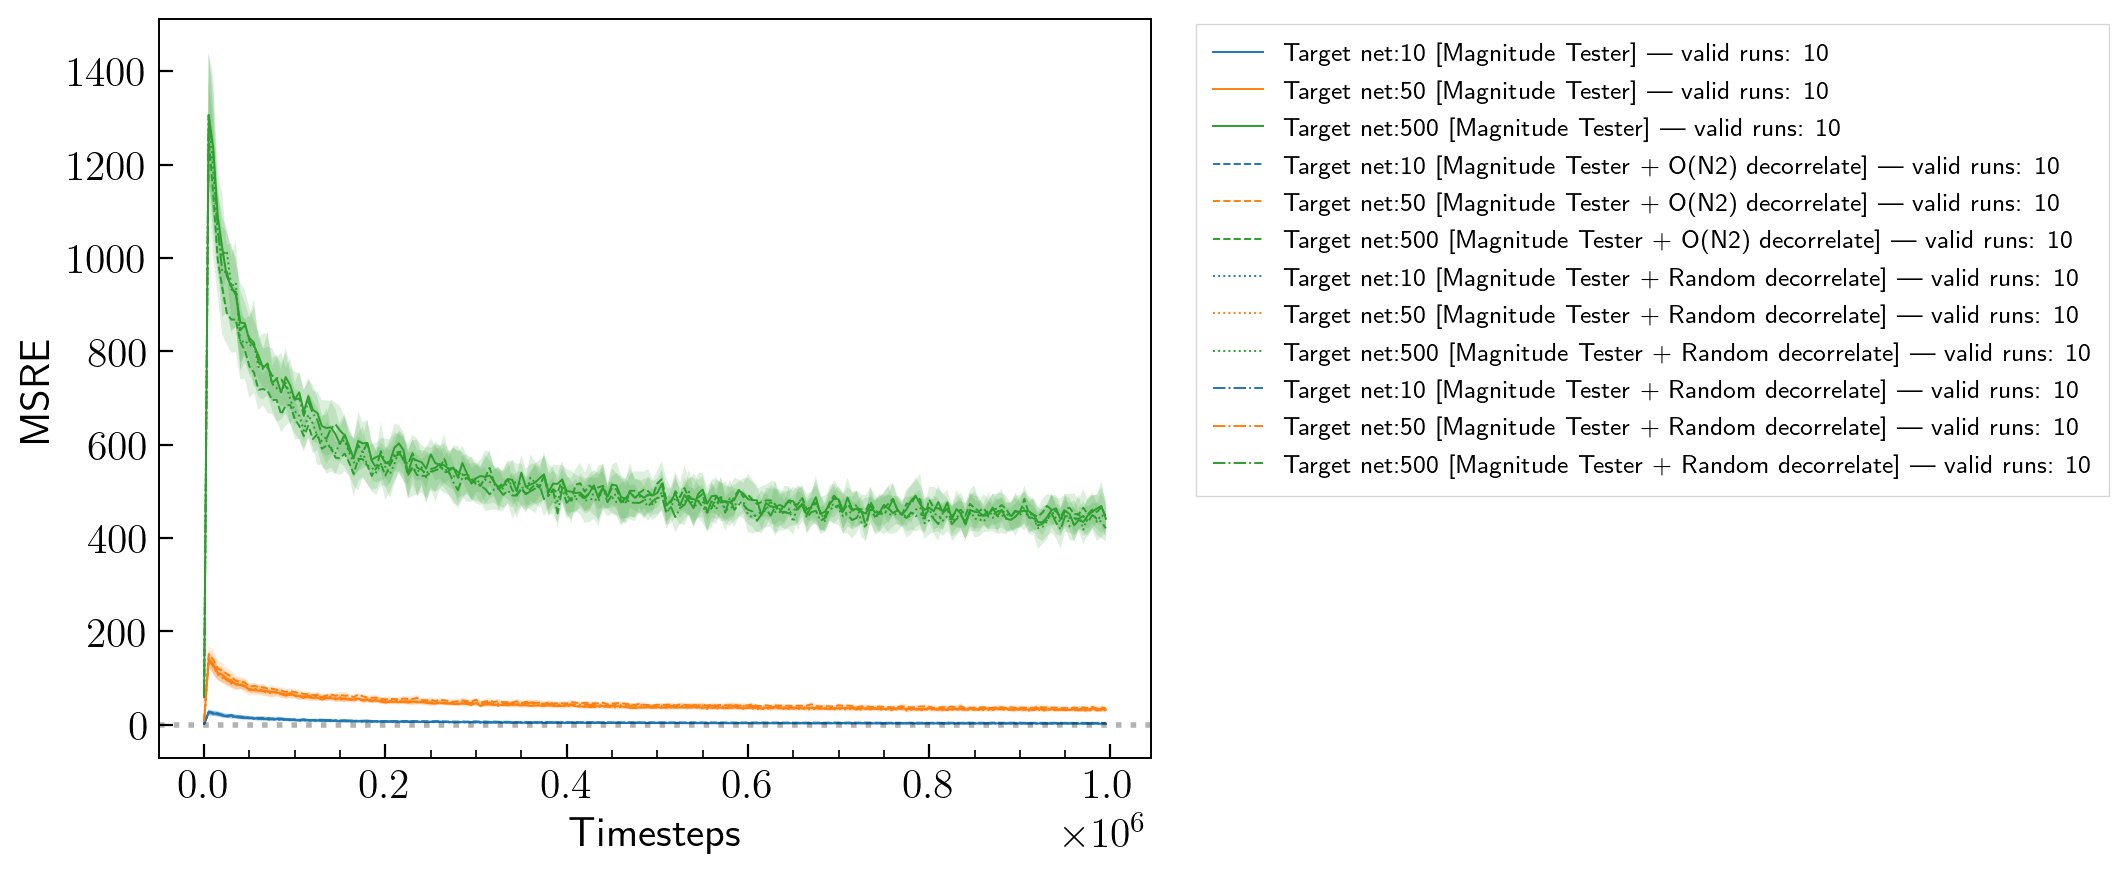

In [26]:

plt_name = f''
fig, axs = plt.subplots(dpi=200)
plt.title(plt_name)
#plt.title(plt_name)
plt.xlabel('Timesteps')
plt.ylabel('MSRE')
axs.xaxis.set_tick_params(which='major', bottom=True)
axs.xaxis.set_tick_params(which='minor', bottom=True)
axs.minorticks_on()

colors = plt.cycler(color=sns.color_palette("Set1", n_colors=10)).by_key()['color']
#colors = plt.cycler(color=sns.color_palette("tab10", n_colors=4)).by_key()['color']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

color_idx = 0
for n_target_features in [10,50, 500]:
    conditions = [["n_target_features", n_target_features],
                 ['n2_decorrelate', 0],
                 ['random_decorrelate', 0],
                 ['step_size', 0.007]]
    plt_with_err("", 200, 0, db1, colors[color_idx], f'Target net:{n_target_features} [Magnitude Tester]', conditions, "error_table", plot_conf=True, pkey_col = "run", nocomment=True, linewidth=0.7, linestyle="-")
    color_idx+=1


color_idx = 0
for n_target_features, ss in zip([10,50, 500], [0.009, 0.01, 0.003]):
    conditions = [["n_target_features", n_target_features],
                 ['n2_decorrelate', 1],
                  ['step_size', ss]]
    plt_with_err("", 200, 0, db1, colors[color_idx], f'Target net:{n_target_features} [Magnitude Tester + O(N2) decorrelate]', conditions, "error_table", plot_conf=True, pkey_col = "run", nocomment=True, linewidth=0.7, linestyle="--")
    color_idx+=1

color_idx = 0
for n_target_features, ss in zip([10,50, 500],[0.005, 0.005, 0.007]):
    conditions = [["n_target_features", n_target_features],
                     ['random_decorrelate', 1],
                  ['min_estimation_period', 5000],
                  ['step_size', ss]]
    plt_with_err("", 200, 0, db2, colors[color_idx], f'Target net:{n_target_features} [Magnitude Tester + Random decorrelate]', conditions, "error_table", plot_conf=True, pkey_col = "run", nocomment=True, linewidth=0.7, linestyle=":")
    color_idx+=1

color_idx = 0
for n_target_features, ss in zip([10,50, 500],[0.005, 0.003, 0.007]):
    conditions = [["n_target_features", n_target_features],
                     ['random_thresh_decorrelate', 1],
                  ['min_estimation_period', 5000],
                  ['step_size', ss]]
    plt_with_err("", 200, 0, db3, colors[color_idx], f'Target net:{n_target_features} [Magnitude Tester + Random Thresh decorrelate]', conditions, "error_table", plot_conf=True, pkey_col = "run", nocomment=True, linewidth=0.7, linestyle="-.")
    color_idx+=1
legend = plt.legend(prop={'size': 9}, bbox_to_anchor=(1.04,1), loc="upper left")
plt.axhline(y=0.00, color='black', linestyle=':', linewidth=2, alpha=0.3)

frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.yscale('linear')
#fig.axes[0].set_ylim(top=90)
#plt.savefig('figures/plt_mnist.svg', bbox_inches='tight')
plt.show()

	 Found 10 valid runs for [['n_target_features', 500], ['n2_decorrelate', 0], ['random_decorrelate', 0], ['step_size', 0.007]]
	 Found 10 valid runs for [['n_target_features', 500], ['n2_decorrelate', 1], ['step_size', 0.003]]
	 Found 10 valid runs for [['n_target_features', 500], ['random_decorrelate', 1], ['min_estimation_period', 5000], ['step_size', 0.007]]
	 Found 10 valid runs for [['n_target_features', 500], ['random_thresh_decorrelate', 1], ['min_estimation_period', 5000], ['step_size', 0.007]]


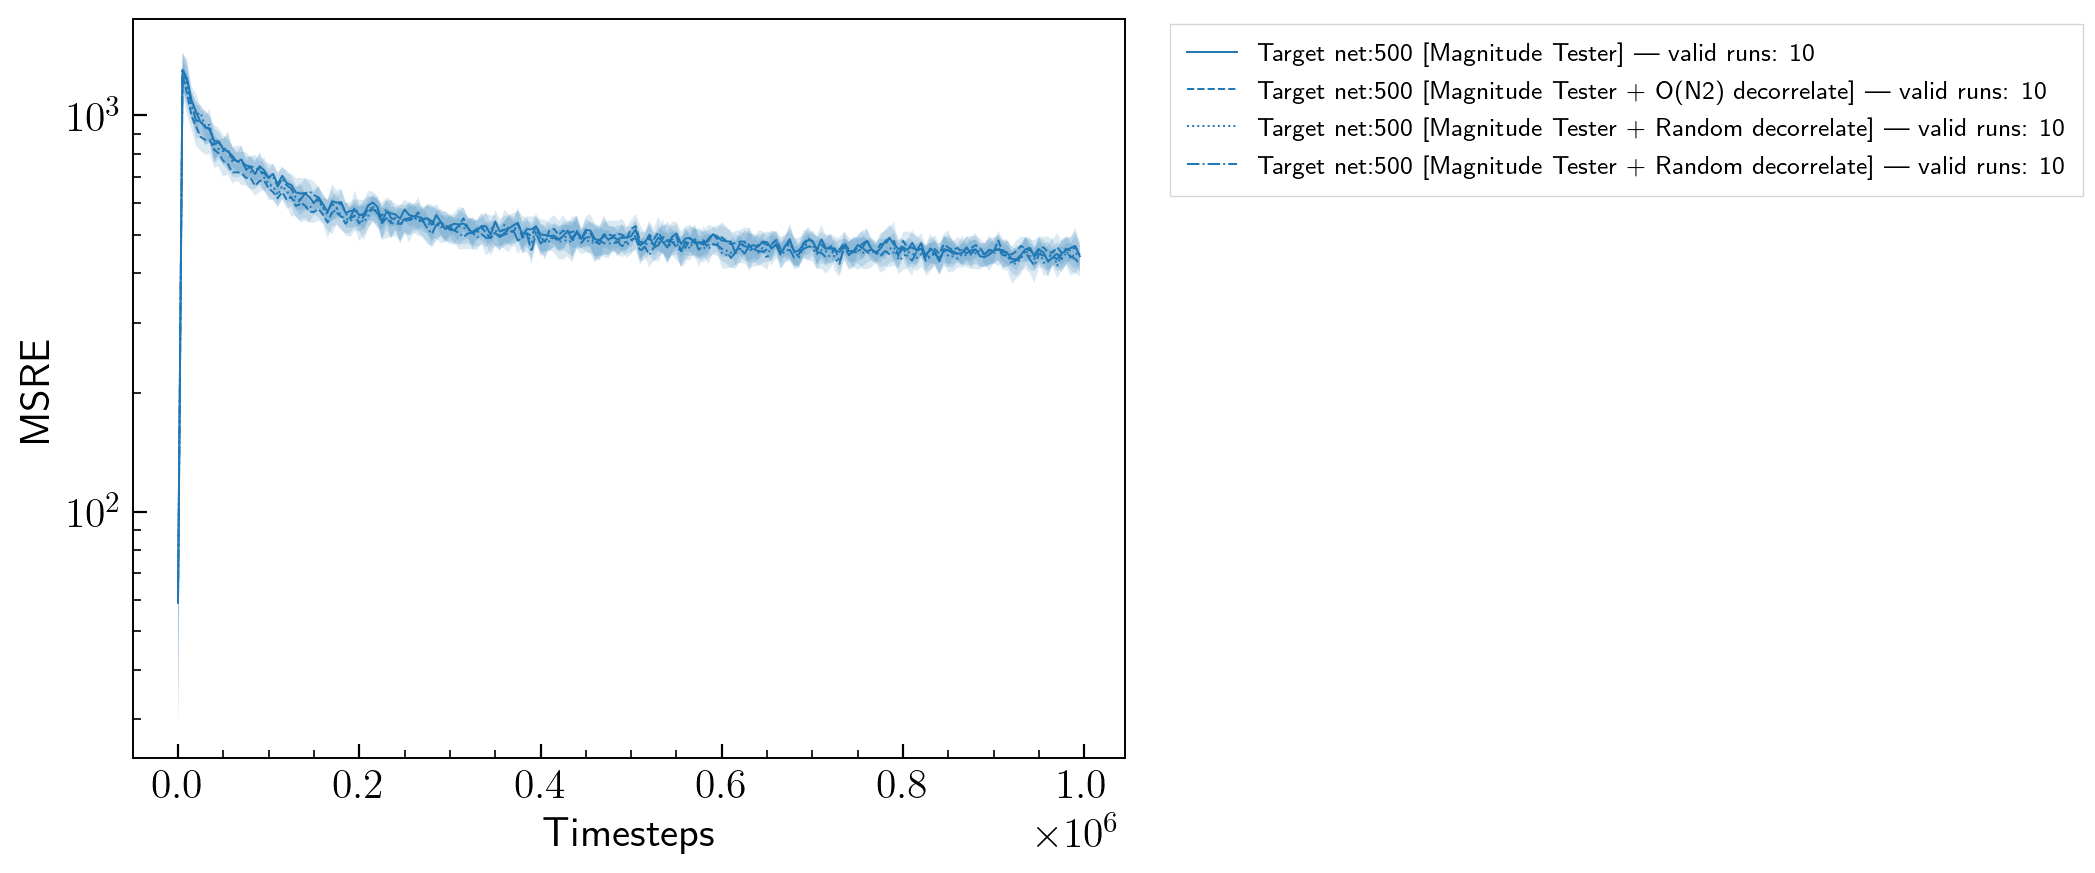

In [25]:

plt_name = f''
fig, axs = plt.subplots(dpi=200)
plt.title(plt_name)
#plt.title(plt_name)
plt.xlabel('Timesteps')
plt.ylabel('MSRE')
axs.xaxis.set_tick_params(which='major', bottom=True)
axs.xaxis.set_tick_params(which='minor', bottom=True)
axs.minorticks_on()

colors = plt.cycler(color=sns.color_palette("Set1", n_colors=10)).by_key()['color']
#colors = plt.cycler(color=sns.color_palette("tab10", n_colors=4)).by_key()['color']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

color_idx = 0
for n_target_features in [500]:
    conditions = [["n_target_features", n_target_features],
                 ['n2_decorrelate', 0],
                 ['random_decorrelate', 0],
                 ['step_size', 0.007]]
    plt_with_err("", 200, 0, db1, colors[color_idx], f'Target net:{n_target_features} [Magnitude Tester]', conditions, "error_table", plot_conf=True, pkey_col = "run", nocomment=True, linewidth=0.7, linestyle="-")
    color_idx+=1


color_idx = 0
for n_target_features, ss in zip([500], [0.003]):
    conditions = [["n_target_features", n_target_features],
                 ['n2_decorrelate', 1],
                  ['step_size', ss]]
    plt_with_err("", 200, 0, db1, colors[color_idx], f'Target net:{n_target_features} [Magnitude Tester + O(N2) decorrelate]', conditions, "error_table", plot_conf=True, pkey_col = "run", nocomment=True, linewidth=0.7, linestyle="--")
    color_idx+=1

color_idx = 0
for n_target_features, ss in zip([500],[0.007]):
    conditions = [["n_target_features", n_target_features],
                     ['random_decorrelate', 1],
                  ['min_estimation_period', 5000],
                  ['step_size', ss]]
    plt_with_err("", 200, 0, db2, colors[color_idx], f'Target net:{n_target_features} [Magnitude Tester + Random decorrelate]', conditions, "error_table", plot_conf=True, pkey_col = "run", nocomment=True, linewidth=0.7, linestyle=":")
    color_idx+=1

    color_idx = 0
for n_target_features, ss in zip([500],[ 0.007]):
    conditions = [["n_target_features", n_target_features],
                     ['random_thresh_decorrelate', 1],
                  ['min_estimation_period', 5000],
                  ['step_size', ss]]
    plt_with_err("", 200, 0, db3, colors[color_idx], f'Target net:{n_target_features} [Magnitude Tester + Random decorrelate]', conditions, "error_table", plot_conf=True, pkey_col = "run", nocomment=True, linewidth=0.7, linestyle="-.")
    color_idx+=1
legend = plt.legend(prop={'size': 9}, bbox_to_anchor=(1.04,1), loc="upper left")
#plt.axhline(y=0.00, color='black', linestyle=':', linewidth=2, alpha=0.3)

frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.yscale('log')
#fig.axes[0].set_ylim(top=90)
#plt.savefig('figures/plt_mnist.svg', bbox_inches='tight')
plt.show()

	 Found 10 valid runs for [['n_target_features', 10], ['n2_decorrelate', 0], ['random_decorrelate', 0], ['step_size', 0.007]]
	 Found 10 valid runs for [['n_target_features', 50], ['n2_decorrelate', 0], ['random_decorrelate', 0], ['step_size', 0.007]]
	 Found 10 valid runs for [['n_target_features', 500], ['n2_decorrelate', 0], ['random_decorrelate', 0], ['step_size', 0.007]]
	 Found 10 valid runs for [['n_target_features', 10], ['n2_decorrelate', 1], ['step_size', 0.009]]
	 Found 10 valid runs for [['n_target_features', 50], ['n2_decorrelate', 1], ['step_size', 0.01]]
	 Found 10 valid runs for [['n_target_features', 500], ['n2_decorrelate', 1], ['step_size', 0.003]]
	 Found 10 valid runs for [['n_target_features', 10], ['random_decorrelate', 1], ['min_estimation_period', 5000], ['step_size', 0.005]]
	 Found 10 valid runs for [['n_target_features', 50], ['random_decorrelate', 1], ['min_estimation_period', 5000], ['step_size', 0.005]]
	 Found 10 valid runs for [['n_target_features', 500

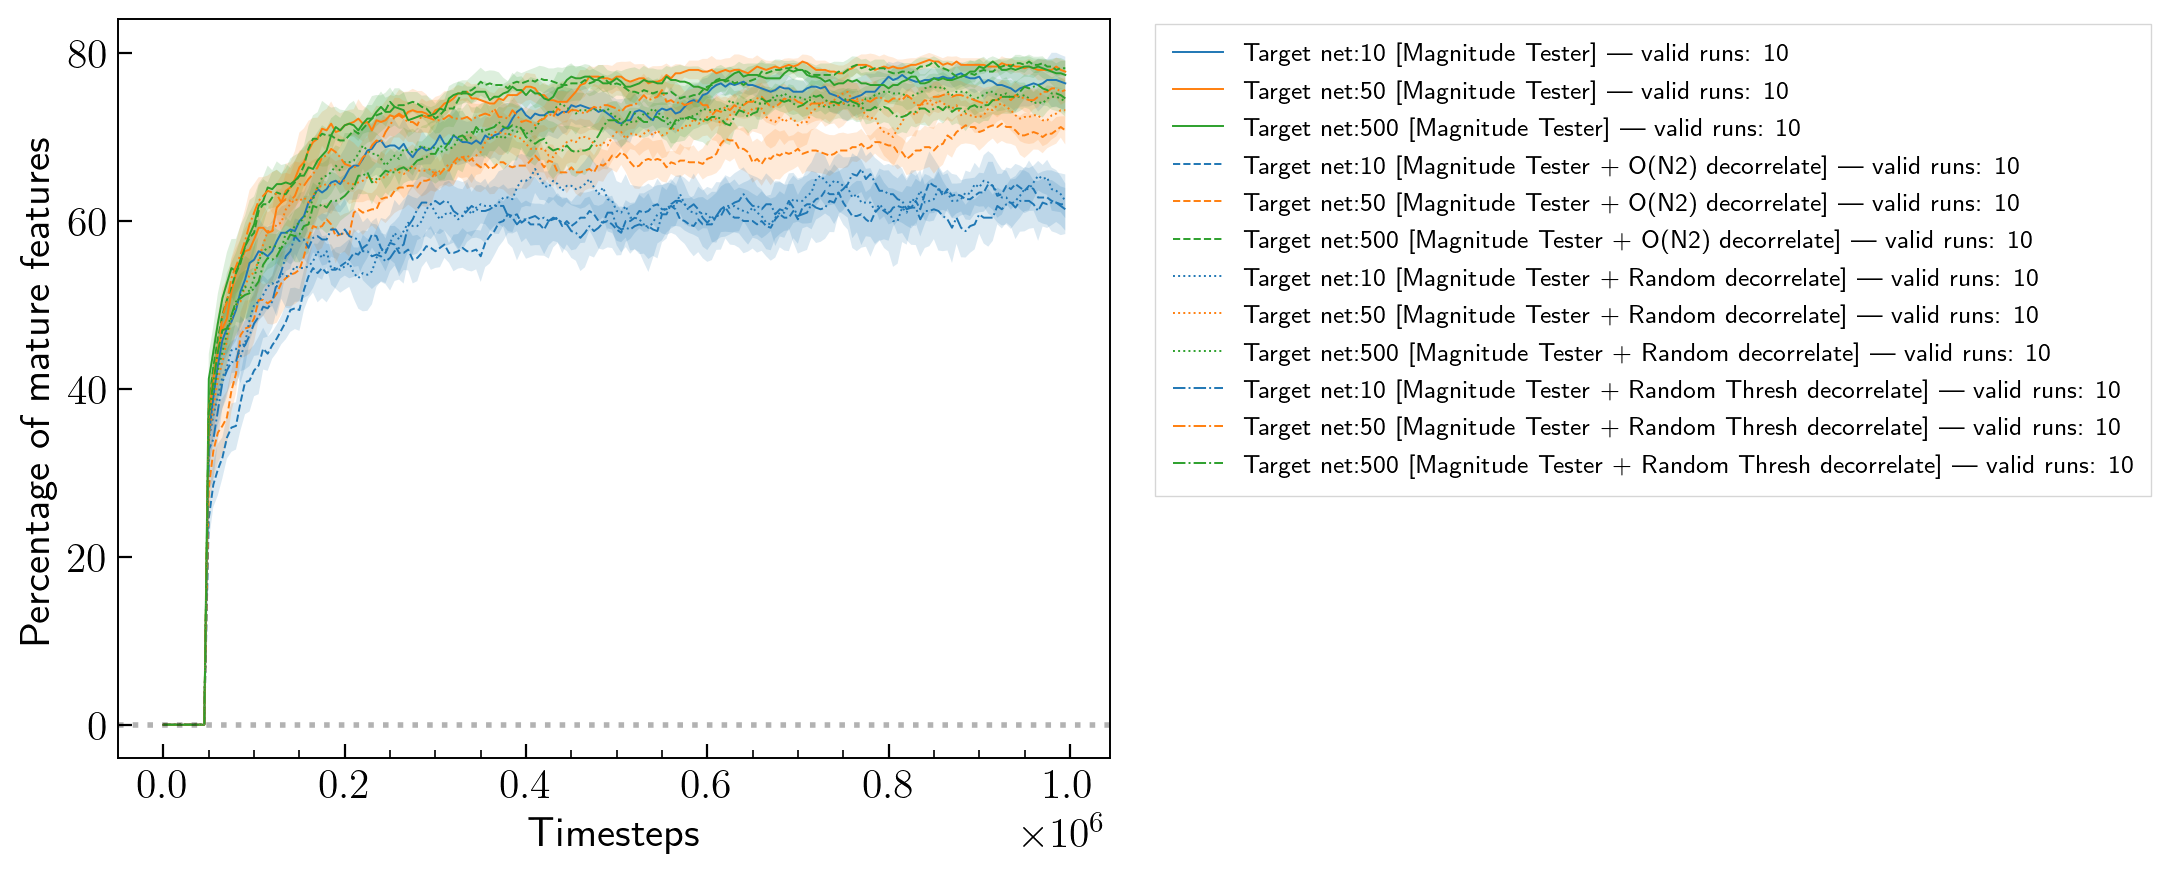

In [28]:

plt_name = f''
fig, axs = plt.subplots(dpi=200)
plt.title(plt_name)
#plt.title(plt_name)
plt.xlabel('Timesteps')
plt.ylabel('Percentage of mature features')
axs.xaxis.set_tick_params(which='major', bottom=True)
axs.xaxis.set_tick_params(which='minor', bottom=True)
axs.minorticks_on()

colors = plt.cycler(color=sns.color_palette("Set1", n_colors=10)).by_key()['color']
#colors = plt.cycler(color=sns.color_palette("tab10", n_colors=4)).by_key()['color']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

color_idx = 0
for n_target_features in [10,50, 500]:
    conditions = [["n_target_features", n_target_features],
                 ['n2_decorrelate', 0],
                 ['random_decorrelate', 0],
                 ['step_size', 0.007]]
    plt_with_err_mature("", 200, 0, db1, colors[color_idx], f'Target net:{n_target_features} [Magnitude Tester]', conditions, "error_table", plot_conf=True, pkey_col = "run", nocomment=True, linewidth=0.7, linestyle="-")
    color_idx+=1


color_idx = 0
for n_target_features, ss in zip([10,50, 500], [0.009, 0.01, 0.003]):
    conditions = [["n_target_features", n_target_features],
                 ['n2_decorrelate', 1],
                  ['step_size', ss]]
    plt_with_err_mature("", 200, 0, db1, colors[color_idx], f'Target net:{n_target_features} [Magnitude Tester + O(N2) decorrelate]', conditions, "error_table", plot_conf=True, pkey_col = "run", nocomment=True, linewidth=0.7, linestyle="--")
    color_idx+=1

color_idx = 0
for n_target_features, ss in zip([10,50, 500],[0.005, 0.005, 0.007]):
    conditions = [["n_target_features", n_target_features],
                     ['random_decorrelate', 1],
                  ['min_estimation_period', 5000],
                  ['step_size', ss]]
    plt_with_err_mature("", 200, 0, db2, colors[color_idx], f'Target net:{n_target_features} [Magnitude Tester + Random decorrelate]', conditions, "error_table", plot_conf=True, pkey_col = "run", nocomment=True, linewidth=0.7, linestyle=":")
    color_idx+=1

color_idx = 0
for n_target_features, ss in zip([10,50, 500],[0.005, 0.003, 0.007]):
    conditions = [["n_target_features", n_target_features],
                     ['random_thresh_decorrelate', 1],
                  ['min_estimation_period', 5000],
                  ['step_size', ss]]
    plt_with_err_mature("", 200, 0, db3, colors[color_idx], f'Target net:{n_target_features} [Magnitude Tester + Random Thresh decorrelate]', conditions, "error_table", plot_conf=True, pkey_col = "run", nocomment=True, linewidth=0.7, linestyle="-.")
    color_idx+=1
    
    
legend = plt.legend(prop={'size': 9}, bbox_to_anchor=(1.04,1), loc="upper left")
plt.axhline(y=0.00, color='black', linestyle=':', linewidth=2, alpha=0.3)

frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.yscale('linear')
#fig.axes[0].set_ylim(top=90)
#plt.savefig('figures/plt_mnist.svg', bbox_inches='tight')
plt.show()

	 Found 10 valid runs for [['n_target_features', 500], ['n2_decorrelate', 0], ['random_decorrelate', 0], ['step_size', 0.007]]
	 Found 10 valid runs for [['n_target_features', 500], ['n2_decorrelate', 1], ['step_size', 0.003]]
	 Found 10 valid runs for [['n_target_features', 500], ['random_decorrelate', 1], ['min_estimation_period', 5000], ['step_size', 0.007]]
	 Found 10 valid runs for [['n_target_features', 500], ['random_thresh_decorrelate', 1], ['min_estimation_period', 5000], ['step_size', 0.007]]


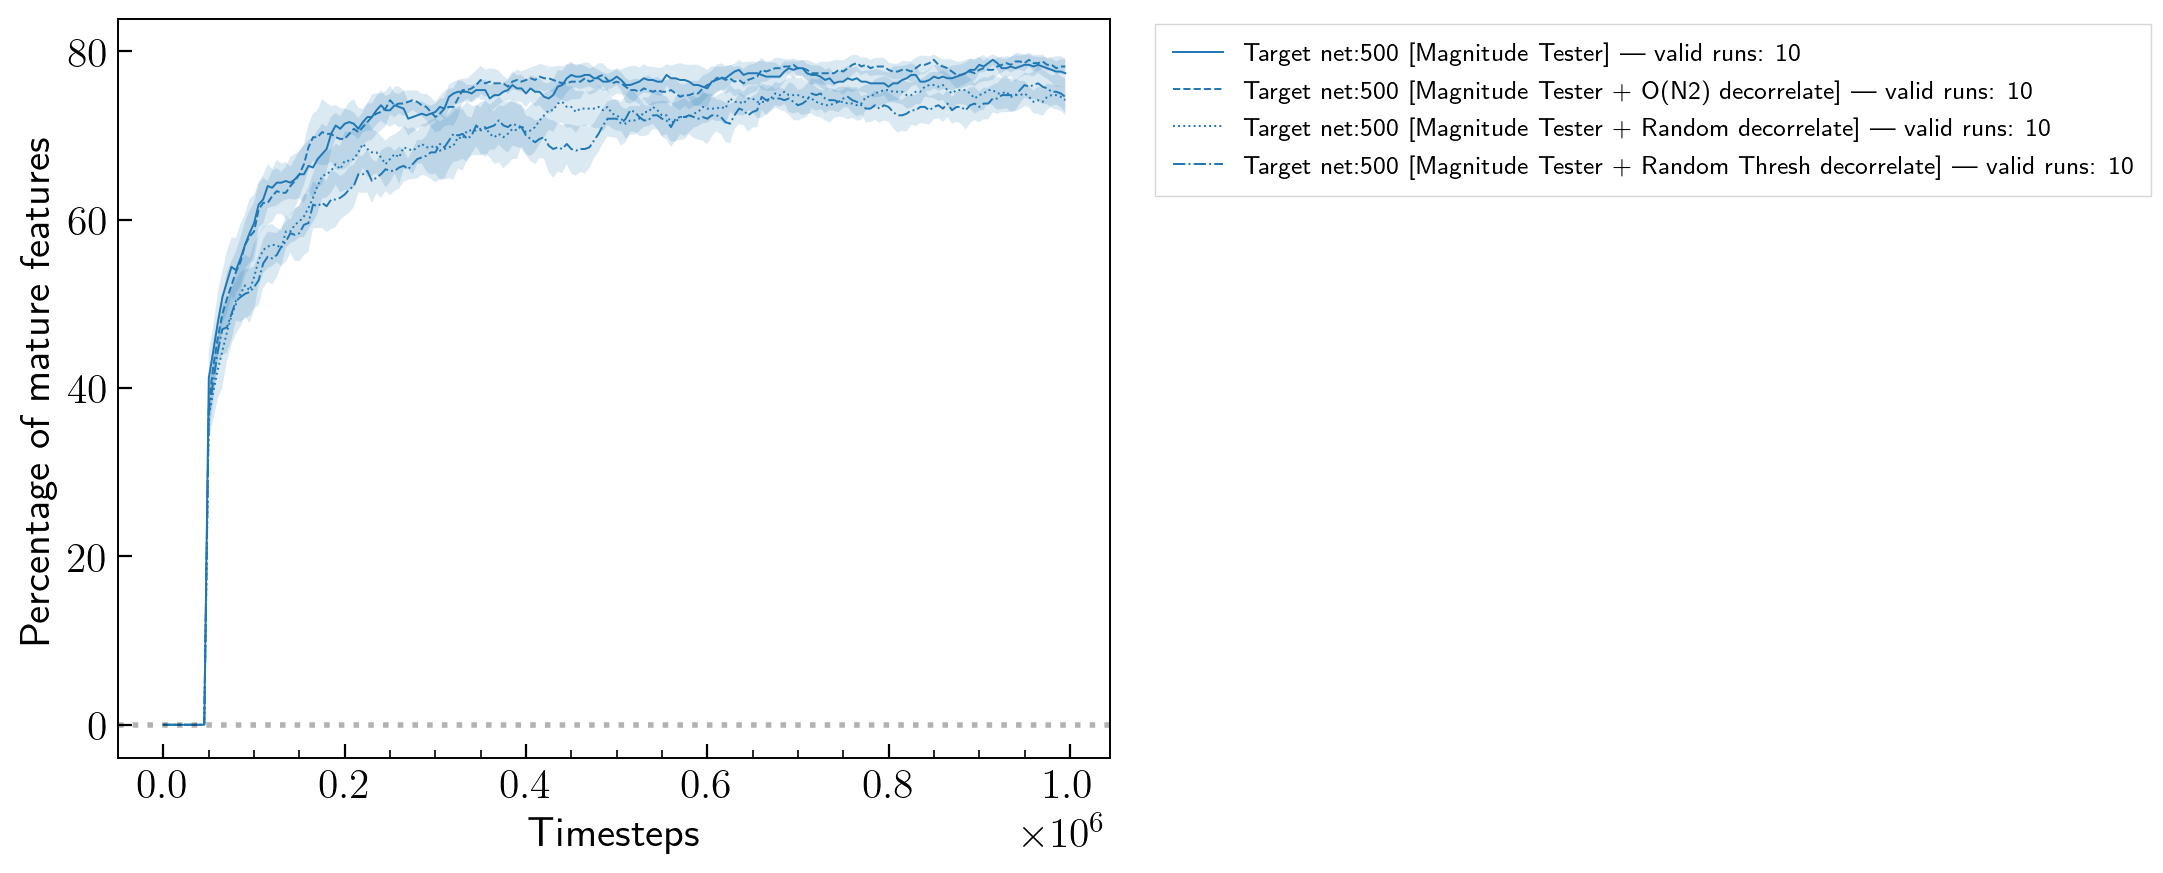

In [29]:

plt_name = f''
fig, axs = plt.subplots(dpi=200)
plt.title(plt_name)
#plt.title(plt_name)
plt.xlabel('Timesteps')
plt.ylabel('Percentage of mature features')
axs.xaxis.set_tick_params(which='major', bottom=True)
axs.xaxis.set_tick_params(which='minor', bottom=True)
axs.minorticks_on()

colors = plt.cycler(color=sns.color_palette("Set1", n_colors=10)).by_key()['color']
#colors = plt.cycler(color=sns.color_palette("tab10", n_colors=4)).by_key()['color']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

color_idx = 0
for n_target_features in [500]:
    conditions = [["n_target_features", n_target_features],
                 ['n2_decorrelate', 0],
                 ['random_decorrelate', 0],
                 ['step_size', 0.007]]
    plt_with_err_mature("", 200, 0, db1, colors[color_idx], f'Target net:{n_target_features} [Magnitude Tester]', conditions, "error_table", plot_conf=True, pkey_col = "run", nocomment=True, linewidth=0.7, linestyle="-")
    color_idx+=1


color_idx = 0
for n_target_features, ss in zip([500], [0.003]):
    conditions = [["n_target_features", n_target_features],
                 ['n2_decorrelate', 1],
                  ['step_size', ss]]
    plt_with_err_mature("", 200, 0, db1, colors[color_idx], f'Target net:{n_target_features} [Magnitude Tester + O(N2) decorrelate]', conditions, "error_table", plot_conf=True, pkey_col = "run", nocomment=True, linewidth=0.7, linestyle="--")
    color_idx+=1

color_idx = 0
for n_target_features, ss in zip([500],[0.007]):
    conditions = [["n_target_features", n_target_features],
                     ['random_decorrelate', 1],
                  ['min_estimation_period', 5000],
                  ['step_size', ss]]
    plt_with_err_mature("", 200, 0, db2, colors[color_idx], f'Target net:{n_target_features} [Magnitude Tester + Random decorrelate]', conditions, "error_table", plot_conf=True, pkey_col = "run", nocomment=True, linewidth=0.7, linestyle=":")
    color_idx+=1

color_idx = 0
for n_target_features, ss in zip([500],[0.007]):
    conditions = [["n_target_features", n_target_features],
                     ['random_thresh_decorrelate', 1],
                  ['min_estimation_period', 5000],
                  ['step_size', ss]]
    plt_with_err_mature("", 200, 0, db3, colors[color_idx], f'Target net:{n_target_features} [Magnitude Tester + Random Thresh decorrelate]', conditions, "error_table", plot_conf=True, pkey_col = "run", nocomment=True, linewidth=0.7, linestyle="-.")
    color_idx+=1
    
    
legend = plt.legend(prop={'size': 9}, bbox_to_anchor=(1.04,1), loc="upper left")
plt.axhline(y=0.00, color='black', linestyle=':', linewidth=2, alpha=0.3)

frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.yscale('linear')
#fig.axes[0].set_ylim(top=90)
#plt.savefig('figures/plt_mnist.svg', bbox_inches='tight')
plt.show()

	 Found 10 valid runs for [['n_target_features', 10], ['n2_decorrelate', 0], ['random_decorrelate', 0], ['step_size', 0.007]]
	 Found 10 valid runs for [['n_target_features', 50], ['n2_decorrelate', 0], ['random_decorrelate', 0], ['step_size', 0.007]]
	 Found 10 valid runs for [['n_target_features', 500], ['n2_decorrelate', 0], ['random_decorrelate', 0], ['step_size', 0.007]]
	 Found 10 valid runs for [['n_target_features', 10], ['n2_decorrelate', 1], ['step_size', 0.009]]
	 Found 10 valid runs for [['n_target_features', 50], ['n2_decorrelate', 1], ['step_size', 0.01]]
	 Found 10 valid runs for [['n_target_features', 500], ['n2_decorrelate', 1], ['step_size', 0.003]]
	 Found 10 valid runs for [['n_target_features', 10], ['random_decorrelate', 1], ['min_estimation_period', 5000], ['step_size', 0.005]]
	 Found 10 valid runs for [['n_target_features', 50], ['random_decorrelate', 1], ['min_estimation_period', 5000], ['step_size', 0.005]]
	 Found 10 valid runs for [['n_target_features', 500

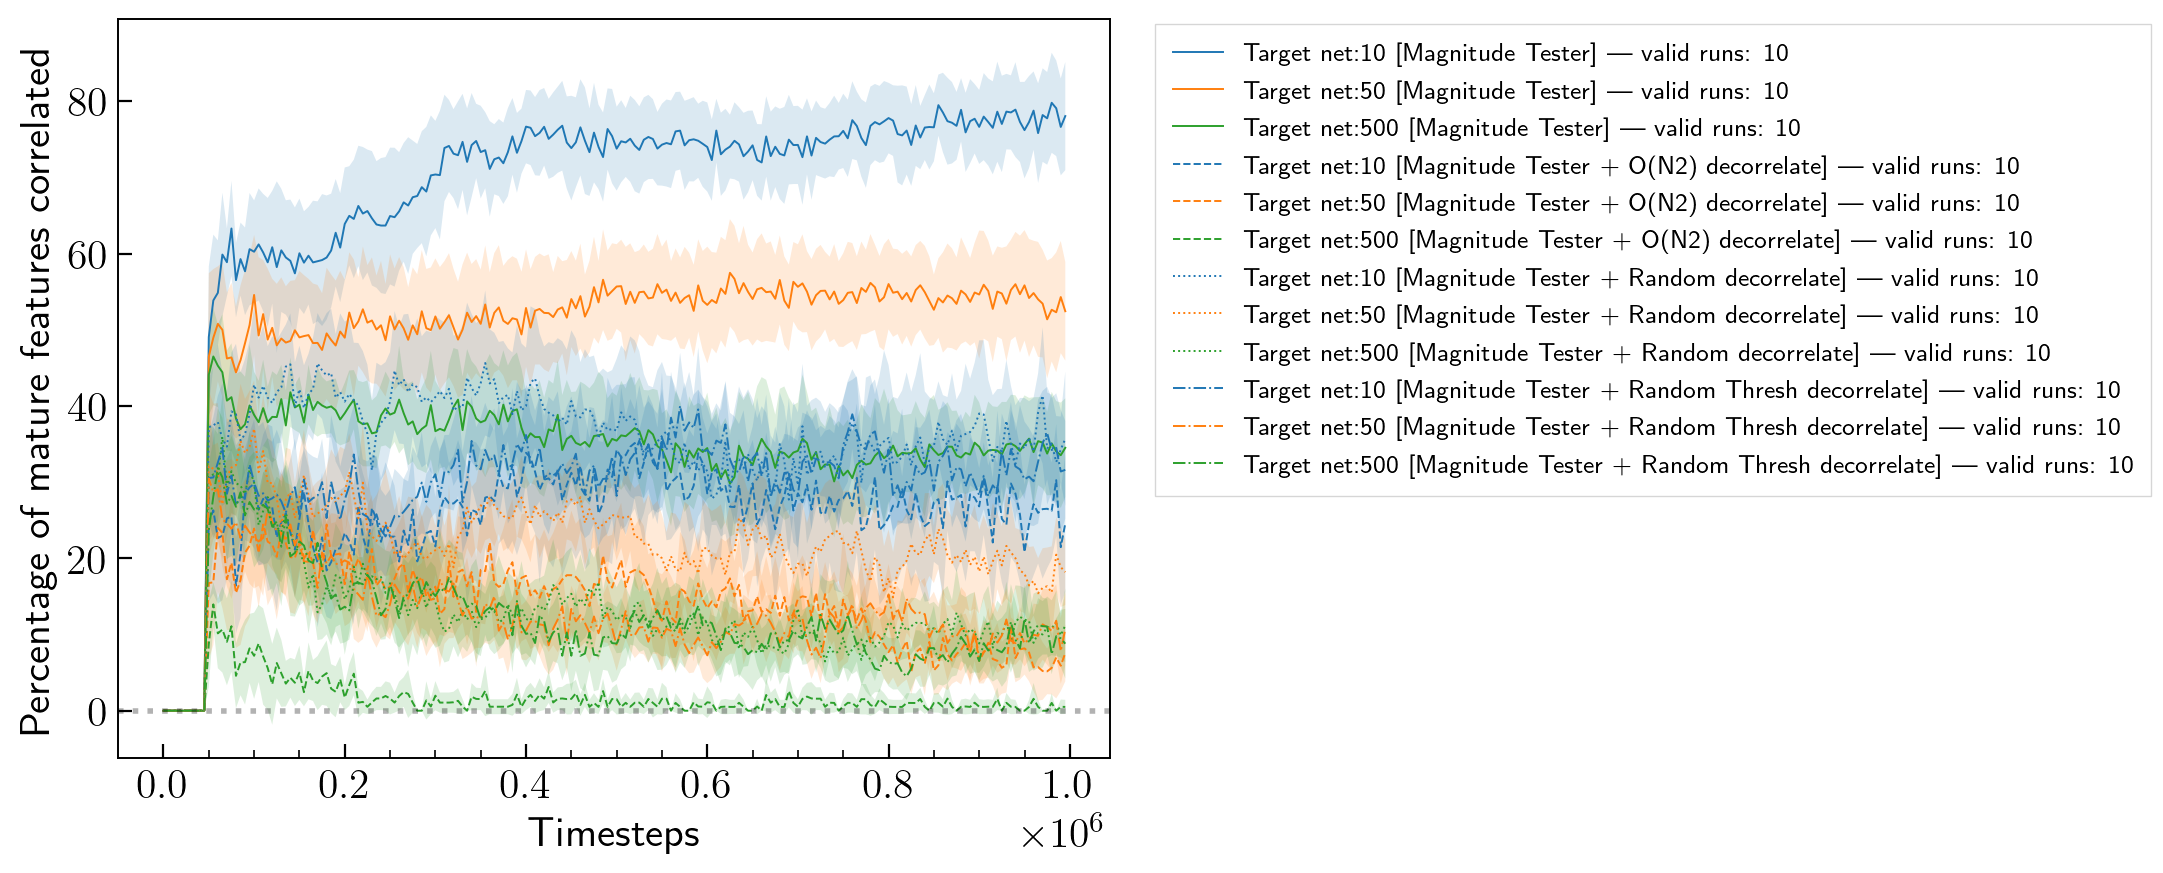

In [34]:

plt_name = f''
fig, axs = plt.subplots(dpi=200)
plt.title(plt_name)
#plt.title(plt_name)
plt.xlabel('Timesteps')
plt.ylabel('Percentage of mature features correlated')
axs.xaxis.set_tick_params(which='major', bottom=True)
axs.xaxis.set_tick_params(which='minor', bottom=True)
axs.minorticks_on()

colors = plt.cycler(color=sns.color_palette("Set1", n_colors=10)).by_key()['color']
#colors = plt.cycler(color=sns.color_palette("tab10", n_colors=4)).by_key()['color']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

color_idx = 0
for n_target_features in [10,50, 500]:
    conditions = [["n_target_features", n_target_features],
                 ['n2_decorrelate', 0],
                 ['random_decorrelate', 0],
                 ['step_size', 0.007]]
    plt_with_err_corr("", 200, 0, db1, colors[color_idx], f'Target net:{n_target_features} [Magnitude Tester]', conditions, "error_table", plot_conf=True, pkey_col = "run", nocomment=True, linewidth=0.7, linestyle="-")
    color_idx+=1
    
color_idx = 0
for n_target_features, ss in zip([10,50, 500], [0.009, 0.01, 0.003]):
    conditions = [["n_target_features", n_target_features],
                 ['n2_decorrelate', 1],
                  ['step_size', ss]]
    plt_with_err_corr("", 200, 0, db1, colors[color_idx], f'Target net:{n_target_features} [Magnitude Tester + O(N2) decorrelate]', conditions, "error_table", plot_conf=True, pkey_col = "run", nocomment=True, linewidth=0.7, linestyle="--")
    color_idx+=1

color_idx = 0
for n_target_features, ss in zip([10,50, 500],[0.005, 0.005, 0.007]):
    conditions = [["n_target_features", n_target_features],
                     ['random_decorrelate', 1],
                  ['min_estimation_period', 5000],
                  ['step_size', ss]]
    plt_with_err_corr("", 200, 0, db2, colors[color_idx], f'Target net:{n_target_features} [Magnitude Tester + Random decorrelate]', conditions, "error_table", plot_conf=True, pkey_col = "run", nocomment=True, linewidth=0.7, linestyle=":")
    color_idx+=1
 
color_idx = 0
for n_target_features, ss in zip([10,50, 500],[0.005, 0.003, 0.007]):
    conditions = [["n_target_features", n_target_features],
                     ['random_thresh_decorrelate', 1],
                  ['min_estimation_period', 5000],
                  ['step_size', ss]]
    plt_with_err_corr("", 200, 0, db3, colors[color_idx], f'Target net:{n_target_features} [Magnitude Tester + Random Thresh decorrelate]', conditions, "error_table", plot_conf=True, pkey_col = "run", nocomment=True, linewidth=0.7, linestyle="-.")
    color_idx+=1

legend = plt.legend(prop={'size': 9}, bbox_to_anchor=(1.04,1), loc="upper left")
plt.axhline(y=0.00, color='black', linestyle=':', linewidth=2, alpha=0.3)

frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.yscale('linear')
#fig.axes[0].set_ylim(top=90)
#plt.savefig('figures/plt_mnist.svg', bbox_inches='tight')
plt.show()

	 Found 10 valid runs for [['n_target_features', 500], ['n2_decorrelate', 0], ['random_decorrelate', 0], ['step_size', 0.007]]
	 Found 10 valid runs for [['n_target_features', 500], ['n2_decorrelate', 1], ['step_size', 0.003]]
	 Found 10 valid runs for [['n_target_features', 500], ['random_decorrelate', 1], ['min_estimation_period', 5000], ['step_size', 0.007]]
	 Found 10 valid runs for [['n_target_features', 500], ['random_thresh_decorrelate', 1], ['min_estimation_period', 5000], ['step_size', 0.007]]


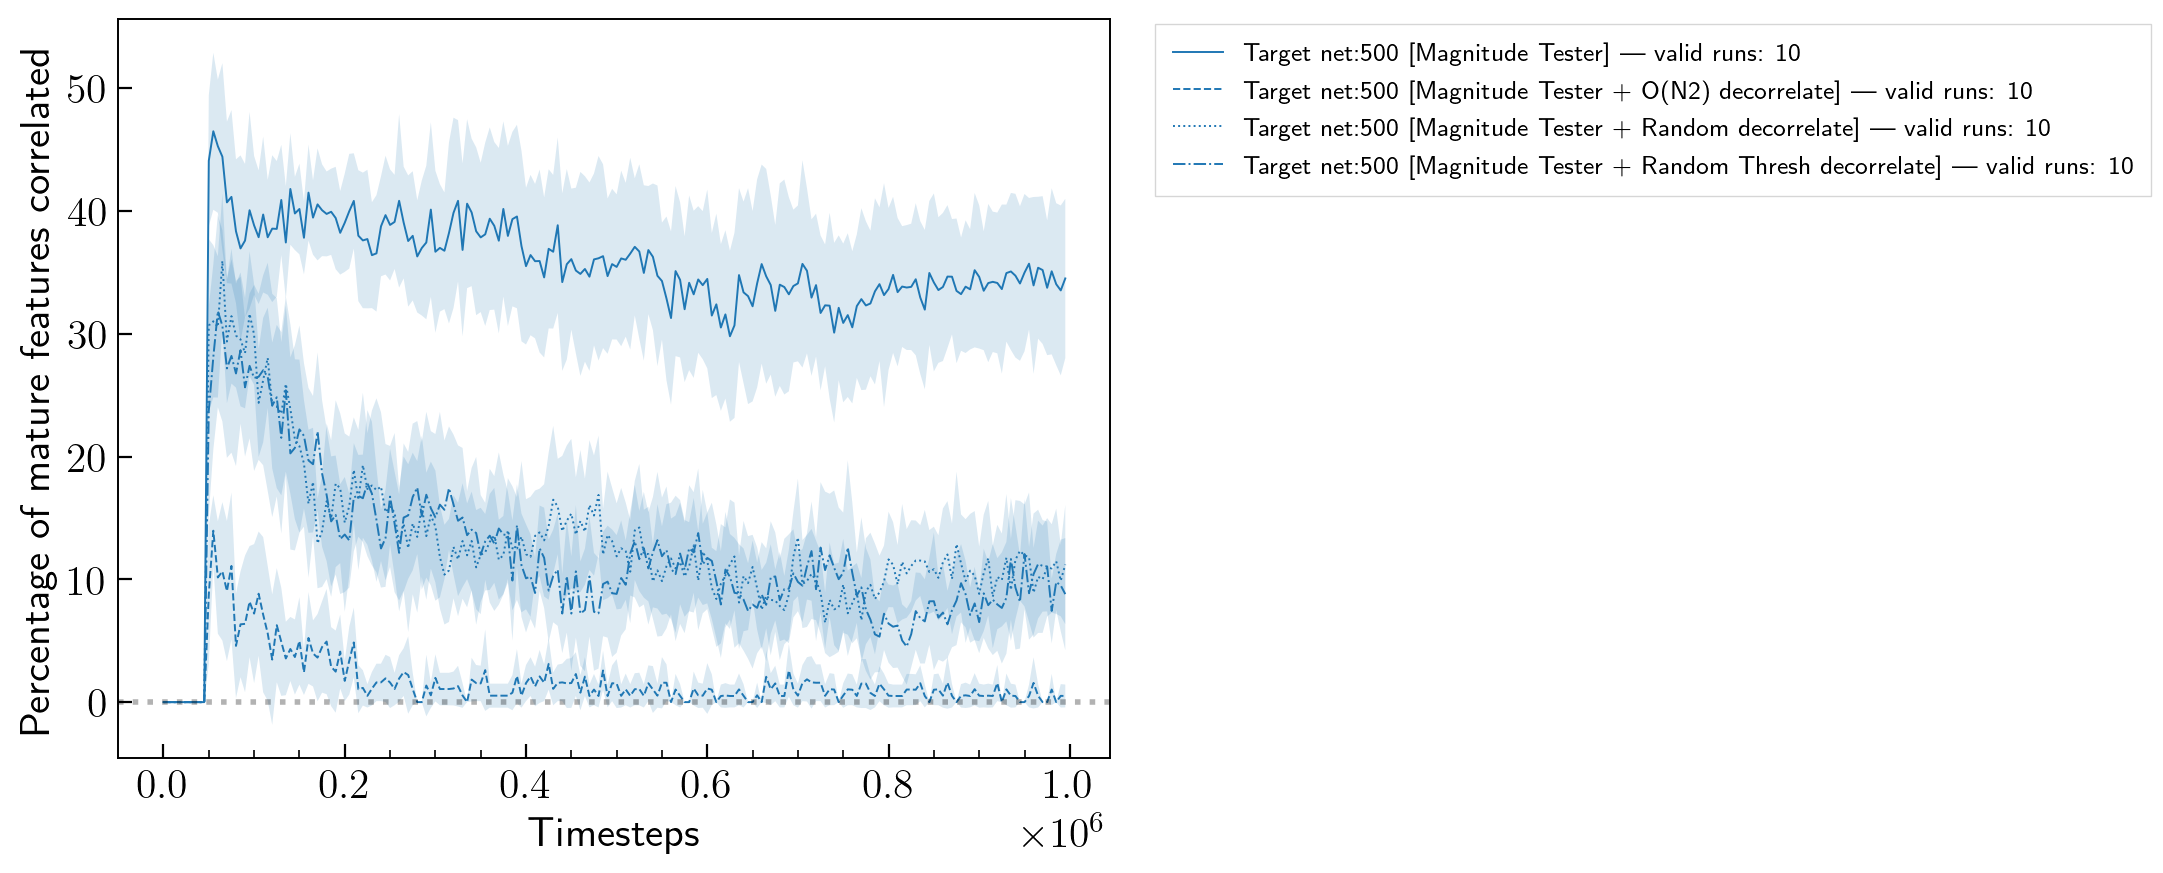

In [33]:

plt_name = f''
fig, axs = plt.subplots(dpi=200)
plt.title(plt_name)
#plt.title(plt_name)
plt.xlabel('Timesteps')
plt.ylabel('Percentage of mature features correlated')
axs.xaxis.set_tick_params(which='major', bottom=True)
axs.xaxis.set_tick_params(which='minor', bottom=True)
axs.minorticks_on()

colors = plt.cycler(color=sns.color_palette("Set1", n_colors=10)).by_key()['color']
#colors = plt.cycler(color=sns.color_palette("tab10", n_colors=4)).by_key()['color']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

color_idx = 0
for n_target_features in [500]:
    conditions = [["n_target_features", n_target_features],
                 ['n2_decorrelate', 0],
                 ['random_decorrelate', 0],
                 ['step_size', 0.007]]
    plt_with_err_corr("", 200, 0, db1, colors[color_idx], f'Target net:{n_target_features} [Magnitude Tester]', conditions, "error_table", plot_conf=True, pkey_col = "run", nocomment=True, linewidth=0.7, linestyle="-")
    color_idx+=1
    
color_idx = 0
for n_target_features, ss in zip([500], [0.003]):
    conditions = [["n_target_features", n_target_features],
                 ['n2_decorrelate', 1],
                  ['step_size', ss]]
    plt_with_err_corr("", 200, 0, db1, colors[color_idx], f'Target net:{n_target_features} [Magnitude Tester + O(N2) decorrelate]', conditions, "error_table", plot_conf=True, pkey_col = "run", nocomment=True, linewidth=0.7, linestyle="--")
    color_idx+=1

color_idx = 0
for n_target_features, ss in zip([500],[0.007]):
    conditions = [["n_target_features", n_target_features],
                     ['random_decorrelate', 1],
                  ['min_estimation_period', 5000],
                  ['step_size', ss]]
    plt_with_err_corr("", 200, 0, db2, colors[color_idx], f'Target net:{n_target_features} [Magnitude Tester + Random decorrelate]', conditions, "error_table", plot_conf=True, pkey_col = "run", nocomment=True, linewidth=0.7, linestyle=":")
    color_idx+=1
 
color_idx = 0
for n_target_features, ss in zip([500],[0.007]):
    conditions = [["n_target_features", n_target_features],
                     ['random_thresh_decorrelate', 1],
                  ['min_estimation_period', 5000],
                  ['step_size', ss]]
    plt_with_err_corr("", 200, 0, db3, colors[color_idx], f'Target net:{n_target_features} [Magnitude Tester + Random Thresh decorrelate]', conditions, "error_table", plot_conf=True, pkey_col = "run", nocomment=True, linewidth=0.7, linestyle="-.")
    color_idx+=1

legend = plt.legend(prop={'size': 9}, bbox_to_anchor=(1.04,1), loc="upper left")
plt.axhline(y=0.00, color='black', linestyle=':', linewidth=2, alpha=0.3)

frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.yscale('linear')
#fig.axes[0].set_ylim(top=90)
#plt.savefig('figures/plt_mnist.svg', bbox_inches='tight')
plt.show()

In [ ]:

plt_name = f''
fig, axs = plt.subplots(dpi=200)
plt.title(plt_name)
#plt.title(plt_name)
plt.xlabel('Timesteps')
plt.ylabel('Percentage of mature features correlated')
axs.xaxis.set_tick_params(which='major', bottom=True)
axs.xaxis.set_tick_params(which='minor', bottom=True)
axs.minorticks_on()

colors = plt.cycler(color=sns.color_palette("Set1", n_colors=10)).by_key()['color']
#colors = plt.cycler(color=sns.color_palette("tab10", n_colors=4)).by_key()['color']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

color_idx = 0
for n_target_features in [10]:
    conditions = [["n_target_features", n_target_features],
                 ['n2_decorrelate', 0],
                 ['random_decorrelate', 0],
                 ['random_replacement', 0]]
    plt_with_err_corr("", 200, 0, db1, colors[color_idx], f'Target net:{n_target_features} [Magnitude Tester]', conditions, "error_table", plot_conf=True, pkey_col = "run", nocomment=True, linewidth=0.7, linestyle="-")
    color_idx+=1
    
color_idx = 0
for n_target_features in [10]:
    conditions = [["n_target_features", n_target_features],
                     ['n2_decorrelate', 1]]
    plt_with_err_corr("", 200, 0, db1, colors[color_idx], f'Target net:{n_target_features} [Magnitude Tester + O(N2) decorrelate]', conditions, "error_table", plot_conf=True, pkey_col = "run", nocomment=True, linewidth=0.7, linestyle="--")
    color_idx+=1

color_idx = 0
for n_target_features in [10]:
    conditions = [["n_target_features", n_target_features],
                     ['random_decorrelate', 1]]
    plt_with_err_corr("", 200, 0, db1, colors[color_idx], f'Target net:{n_target_features} [Magnitude Tester + Random decorrelate]', conditions, "error_table", plot_conf=True, pkey_col = "run", nocomment=True, linewidth=0.7, linestyle=":")
    color_idx+=1
    
legend = plt.legend(prop={'size': 9}, bbox_to_anchor=(1.04,1), loc="upper left")
plt.axhline(y=0.00, color='black', linestyle=':', linewidth=2, alpha=0.3)

frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.yscale('linear')
#fig.axes[0].set_ylim(top=90)
#plt.savefig('figures/plt_mnist.svg', bbox_inches='tight')
plt.show()

In [ ]:

plt_name = f''
fig, axs = plt.subplots(dpi=200)
plt.title(plt_name)
#plt.title(plt_name)
plt.xlabel('Timesteps')
plt.ylabel('Percentage of mature features correlated')
axs.xaxis.set_tick_params(which='major', bottom=True)
axs.xaxis.set_tick_params(which='minor', bottom=True)
axs.minorticks_on()

colors = plt.cycler(color=sns.color_palette("Set1", n_colors=10)).by_key()['color']
#colors = plt.cycler(color=sns.color_palette("tab10", n_colors=4)).by_key()['color']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

color_idx = 1
for n_target_features in [50]:
    conditions = [["n_target_features", n_target_features],
                 ['n2_decorrelate', 0],
                 ['random_decorrelate', 0],
                 ['random_replacement', 0]]
    plt_with_err_corr("", 200, 0, db1, colors[color_idx], f'Target net:{n_target_features} [Magnitude Tester]', conditions, "error_table", plot_conf=True, pkey_col = "run", nocomment=True, linewidth=0.7, linestyle="-")
    color_idx+=1
    
color_idx = 1
for n_target_features in [50]:
    conditions = [["n_target_features", n_target_features],
                     ['n2_decorrelate', 1]]
    plt_with_err_corr("", 200, 0, db1, colors[color_idx], f'Target net:{n_target_features} [Magnitude Tester + O(N2) decorrelate]', conditions, "error_table", plot_conf=True, pkey_col = "run", nocomment=True, linewidth=0.7, linestyle="--")
    color_idx+=1

color_idx = 1
for n_target_features in [50]:
    conditions = [["n_target_features", n_target_features],
                     ['random_decorrelate', 1]]
    plt_with_err_corr("", 200, 0, db1, colors[color_idx], f'Target net:{n_target_features} [Magnitude Tester + Random decorrelate]', conditions, "error_table", plot_conf=True, pkey_col = "run", nocomment=True, linewidth=0.7, linestyle=":")
    color_idx+=1
    
legend = plt.legend(prop={'size': 9}, bbox_to_anchor=(1.04,1), loc="upper left")
plt.axhline(y=0.00, color='black', linestyle=':', linewidth=2, alpha=0.3)

frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.yscale('linear')
#fig.axes[0].set_ylim(top=90)
#plt.savefig('figures/plt_mnist.svg', bbox_inches='tight')
plt.show()

In [ ]:

plt_name = f''
fig, axs = plt.subplots(dpi=200)
plt.title(plt_name)
#plt.title(plt_name)
plt.xlabel('Timesteps')
plt.ylabel('Percentage of mature features correlated')
axs.xaxis.set_tick_params(which='major', bottom=True)
axs.xaxis.set_tick_params(which='minor', bottom=True)
axs.minorticks_on()

colors = plt.cycler(color=sns.color_palette("Set1", n_colors=10)).by_key()['color']
#colors = plt.cycler(color=sns.color_palette("tab10", n_colors=4)).by_key()['color']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

color_idx = 2
for n_target_features in [500]:
    conditions = [["n_target_features", n_target_features],
                 ['n2_decorrelate', 0],
                 ['random_decorrelate', 0],
                 ['random_replacement', 0]]
    plt_with_err_corr("", 200, 0, db1, colors[color_idx], f'Target net:{n_target_features} [Magnitude Tester]', conditions, "error_table", plot_conf=True, pkey_col = "run", nocomment=True, linewidth=0.7, linestyle="-")
    color_idx+=1
    
color_idx = 2
for n_target_features in [500]:
    conditions = [["n_target_features", n_target_features],
                     ['n2_decorrelate', 1]]
    plt_with_err_corr("", 200, 0, db1, colors[color_idx], f'Target net:{n_target_features} [Magnitude Tester + O(N2) decorrelate]', conditions, "error_table", plot_conf=True, pkey_col = "run", nocomment=True, linewidth=0.7, linestyle="--")
    color_idx+=1

color_idx = 2
for n_target_features in [500]:
    conditions = [["n_target_features", n_target_features],
                     ['random_decorrelate', 1]]
    plt_with_err_corr("", 200, 0, db1, colors[color_idx], f'Target net:{n_target_features} [Magnitude Tester + Random decorrelate]', conditions, "error_table", plot_conf=True, pkey_col = "run", nocomment=True, linewidth=0.7, linestyle=":")
    color_idx+=1
    
legend = plt.legend(prop={'size': 9}, bbox_to_anchor=(1.04,1), loc="upper left")
plt.axhline(y=0.00, color='black', linestyle=':', linewidth=2, alpha=0.3)

frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.yscale('linear')
#fig.axes[0].set_ylim(top=90)
#plt.savefig('figures/plt_mnist.svg', bbox_inches='tight')
plt.show()

In [ ]:

plt_name = f''
fig, axs = plt.subplots(dpi=200)
plt.title(plt_name)
#plt.title(plt_name)
plt.xlabel('Timesteps')
plt.ylabel('Avg corr of features removed by decorrelator')
axs.xaxis.set_tick_params(which='major', bottom=True)
axs.xaxis.set_tick_params(which='minor', bottom=True)
#axs.minorticks_on()

colors = plt.cycler(color=sns.color_palette("Set1", n_colors=10)).by_key()['color']
#colors = plt.cycler(color=sns.color_palette("tab10", n_colors=4)).by_key()['color']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

color_idx = 0

for p1 in [10]:
    values = pd.read_sql(f'select count(*), step, avg(abs(real_correlation)), 1.96*std(abs(real_correlation))/sqrt(count(*)/2)  from correlated_graphs_table join runs where runs.run = correlated_graphs_table.run and n2_decorrelate={1} and n_target_features={p1} group by step order by step asc', db1.conn)#.values[:,-1]
    if len(values) == 0:
        continue
    total_runs = values.values[:,0]
    x_axis = values.values[:,1]
    acc_mean = values.values[:,2]
    err = values.values[:,3]
    plt.plot(x_axis, acc_mean, label=f"target net: {p1}, [Magnitude Tester + O(N2) decorelate]", color=colors[color_idx], linestyle='--', linewidth=0.7)#, marker='*', markersize=3)
    #plt.fill_between(x_axis, acc_mean-err, acc_mean+err, alpha=0.16, color=colors[color_idx], edgecolor=None)
    color_idx += 1

color_idx = 0

for p1 in [10]:
    values = pd.read_sql(f'select count(*), step, avg(abs(real_correlation)), 1.96*std(abs(real_correlation))/sqrt(count(*)/2)  from correlated_graphs_table join runs where runs.run = correlated_graphs_table.run and random_decorrelate={1} and n_target_features={p1} group by step order by step asc', db1.conn)#.values[:,-1]
    if len(values) == 0:
        continue
    total_runs = values.values[:,0]
    x_axis = values.values[:,1]
    acc_mean = values.values[:,2]
    err = values.values[:,3]
    plt.plot(x_axis, acc_mean, label=f"target net: {p1}, [Magnitude Tester + Random decorelate]", color=colors[color_idx], linestyle=':', linewidth=0.7)#, marker='*', markersize=3)
    #plt.fill_between(x_axis, acc_mean-err, acc_mean+err, alpha=0.16, color=colors[color_idx], edgecolor=None)
    color_idx += 1
        
#plt.axhline(y=0.0021, color='black', linestyle=':', linewidth=2, alpha=0.3)
legend = plt.legend(prop={'size': 9}, bbox_to_anchor=(1.04,1), loc="upper left")
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.yscale('linear')
#fig.axes[0].set_ylim(top=300)
#plt.savefig('figures/plt_mnist.svg', bbox_inches='tight')
plt.show()

In [ ]:

plt_name = f''
fig, axs = plt.subplots(dpi=200)
plt.title(plt_name)
#plt.title(plt_name)
plt.xlabel('Timesteps')
plt.ylabel('Avg corr of features removed by decorrelator')
axs.xaxis.set_tick_params(which='major', bottom=True)
axs.xaxis.set_tick_params(which='minor', bottom=True)
#axs.minorticks_on()

colors = plt.cycler(color=sns.color_palette("Set1", n_colors=10)).by_key()['color']
#colors = plt.cycler(color=sns.color_palette("tab10", n_colors=4)).by_key()['color']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

color_idx = 1

for p1 in [50]:
    values = pd.read_sql(f'select count(*), step, avg(abs(real_correlation)), 1.96*std(abs(real_correlation))/sqrt(count(*)/2)  from correlated_graphs_table join runs where runs.run = correlated_graphs_table.run and n2_decorrelate={1} and n_target_features={p1} group by step order by step asc', db1.conn)#.values[:,-1]
    if len(values) == 0:
        continue
    total_runs = values.values[:,0]
    x_axis = values.values[:,1]
    acc_mean = values.values[:,2]
    err = values.values[:,3]
    plt.plot(x_axis, acc_mean, label=f"target net: {p1}, [Magnitude Tester + O(N2) decorelate]", color=colors[color_idx], linestyle='--', linewidth=0.7)#, marker='*', markersize=3)
    #plt.fill_between(x_axis, acc_mean-err, acc_mean+err, alpha=0.16, color=colors[color_idx], edgecolor=None)
    color_idx += 1

color_idx = 1

for p1 in [50]:
    values = pd.read_sql(f'select count(*), step, avg(abs(real_correlation)), 1.96*std(abs(real_correlation))/sqrt(count(*)/2)  from correlated_graphs_table join runs where runs.run = correlated_graphs_table.run and random_decorrelate={1} and n_target_features={p1} group by step order by step asc', db1.conn)#.values[:,-1]
    if len(values) == 0:
        continue
    total_runs = values.values[:,0]
    x_axis = values.values[:,1]
    acc_mean = values.values[:,2]
    err = values.values[:,3]
    plt.plot(x_axis, acc_mean, label=f"target net: {p1}, [Magnitude Tester + Random decorelate]", color=colors[color_idx], linestyle=':', linewidth=0.7)#, marker='*', markersize=3)
    #plt.fill_between(x_axis, acc_mean-err, acc_mean+err, alpha=0.16, color=colors[color_idx], edgecolor=None)
    color_idx += 1
        
#plt.axhline(y=0.0021, color='black', linestyle=':', linewidth=2, alpha=0.3)
legend = plt.legend(prop={'size': 9}, bbox_to_anchor=(1.04,1), loc="upper left")
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.yscale('linear')
#fig.axes[0].set_ylim(top=300)
#plt.savefig('figures/plt_mnist.svg', bbox_inches='tight')
plt.show()

In [ ]:

plt_name = f''
fig, axs = plt.subplots(dpi=200)
plt.title(plt_name)
#plt.title(plt_name)
plt.xlabel('Timesteps')
plt.ylabel('Avg corr of features removed by decorrelator')
axs.xaxis.set_tick_params(which='major', bottom=True)
axs.xaxis.set_tick_params(which='minor', bottom=True)
#axs.minorticks_on()

colors = plt.cycler(color=sns.color_palette("Set1", n_colors=10)).by_key()['color']
#colors = plt.cycler(color=sns.color_palette("tab10", n_colors=4)).by_key()['color']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

color_idx = 2

for p1 in [500]:
    values = pd.read_sql(f'select count(*), step, avg(abs(real_correlation)), 1.96*std(abs(real_correlation))/sqrt(count(*)/2)  from correlated_graphs_table join runs where runs.run = correlated_graphs_table.run and n2_decorrelate={1} and n_target_features={p1} group by step order by step asc', db1.conn)#.values[:,-1]
    if len(values) == 0:
        continue
    total_runs = values.values[:,0]
    x_axis = values.values[:,1]
    acc_mean = values.values[:,2]
    err = values.values[:,3]
    plt.plot(x_axis, acc_mean, label=f"target net: {p1}, [Magnitude Tester + O(N2) decorelate]", color=colors[color_idx], linestyle='--', linewidth=0.7)#, marker='*', markersize=3)
    #plt.fill_between(x_axis, acc_mean-err, acc_mean+err, alpha=0.16, color=colors[color_idx], edgecolor=None)
    color_idx += 1

color_idx = 2

for p1 in [500]:
    values = pd.read_sql(f'select count(*), step, avg(abs(real_correlation)), 1.96*std(abs(real_correlation))/sqrt(count(*)/2)  from correlated_graphs_table join runs where runs.run = correlated_graphs_table.run and random_decorrelate={1} and n_target_features={p1} group by step order by step asc', db1.conn)#.values[:,-1]
    if len(values) == 0:
        continue
    total_runs = values.values[:,0]
    x_axis = values.values[:,1]
    acc_mean = values.values[:,2]
    err = values.values[:,3]
    plt.plot(x_axis, acc_mean, label=f"target net: {p1}, [Magnitude Tester + Random decorelate]", color=colors[color_idx], linestyle=':', linewidth=0.7)#, marker='*', markersize=3)
    #plt.fill_between(x_axis, acc_mean-err, acc_mean+err, alpha=0.16, color=colors[color_idx], edgecolor=None)
    color_idx += 1
        
#plt.axhline(y=0.0021, color='black', linestyle=':', linewidth=2, alpha=0.3)
legend = plt.legend(prop={'size': 9}, bbox_to_anchor=(1.04,1), loc="upper left")
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.yscale('linear')
#fig.axes[0].set_ylim(top=300)
#plt.savefig('figures/plt_mnist.svg', bbox_inches='tight')
plt.show()

In [ ]:

plt_name = f''
fig, axs = plt.subplots(dpi=200)
plt.title(plt_name)
#plt.title(plt_name)
plt.xlabel('Timesteps')
plt.ylabel('Avg number of features removed by decorrelator')
axs.xaxis.set_tick_params(which='major', bottom=True)
axs.xaxis.set_tick_params(which='minor', bottom=True)
#axs.minorticks_on()

colors = plt.cycler(color=sns.color_palette("Set1", n_colors=10)).by_key()['color']
#colors = plt.cycler(color=sns.color_palette("tab10", n_colors=4)).by_key()['color']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

color_idx = 0

for p1 in [10,50,500]:
    values = pd.read_sql(f'select count(*), step from correlated_graphs_table join runs where runs.run = correlated_graphs_table.run and n2_decorrelate={1} and n_target_features={p1} group by step order by step asc', db1.conn)#.values[:,-1]
    if len(values) == 0:
        continue
    total_runs = values.values[:,0]
    x_axis = values.values[:,1]
    acc_mean = values.values[:,0]/10
    plt.plot(x_axis, acc_mean, label=f"target net: {p1}, [Magnitude Tester + O(N2) decorelate] | avg: {np.mean(total_runs)/10}", color=colors[color_idx], linestyle='--', linewidth=0.7)#, marker='*', markersize=3)
    #plt.fill_between(x_axis, acc_mean-err, acc_mean+err, alpha=0.16, color=colors[color_idx], edgecolor=None)
    color_idx += 1

color_idx = 0

for p1 in [10, 50,500]:
    values = pd.read_sql(f'select count(*), step from correlated_graphs_table join runs where runs.run = correlated_graphs_table.run and random_decorrelate={1} and n_target_features={p1} group by step order by step asc', db1.conn)#.values[:,-1]
    if len(values) == 0:
        continue
    total_runs = values.values[:,0]
    x_axis = values.values[:,1]
    acc_mean = values.values[:,0]/10
    plt.plot(x_axis, acc_mean, label=f"target net: {p1}, [Magnitude Tester + Random decorelate] | avg: {np.mean(total_runs)/10}", color=colors[color_idx], linestyle=':', linewidth=0.7)#, marker='*', markersize=3)
    #plt.fill_between(x_axis, acc_mean-err, acc_mean+err, alpha=0.16, color=colors[color_idx], edgecolor=None)
    color_idx += 1
        
#plt.axhline(y=0.0021, color='black', linestyle=':', linewidth=2, alpha=0.3)
legend = plt.legend(prop={'size': 9}, bbox_to_anchor=(1.04,1), loc="upper left")
frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.yscale('linear')
#fig.axes[0].set_ylim(top=300)
#plt.savefig('figures/plt_mnist.svg', bbox_inches='tight')
plt.show()